In [1]:
# Import libraries
import moments, moments.LD
import pandas as pd, numpy as np
import demes, demesdraw, matplotlib.pylab as plt

In [6]:
# Define Functions
def sample_timepoints(deme, time_points = 3, size = 100):
     sample_demes = list(np.repeat(np.array(deme),time_points))
     times = np.linspace(graph[deme].end_time+1,graph[deme].start_time-1,time_points,dtype=int) if graph[deme].start_time != float('inf') else np.linspace(graph[deme].end_time+1,graph[deme].end_time+4000,time_points,dtype=int)
     sizes = list(np.repeat(np.array(size),time_points))
     return sample_demes,times,sizes

def Dstat(graph,sampled_demes,sample_times,rhos):
     y = moments.Demes.LD(graph, sampled_demes=sampled_demes, sample_times=sample_times,rho = rhos)
     sigma = moments.LD.Inference.sigmaD2(y)
     return sigma

def plot_D(sigma,rhos,sample_times,subfig,ancestral):
     (ax1, ax2, ax3) = subfig.subplots(nrows=1, ncols=3)
     #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

     ax1.plot(rhos, sigma.LD()[:, 0],label=str("tp_"+str(sample_times[0])))
     ax1.plot(rhos, sigma.LD()[:, 3],label=str("tp_"+str(sample_times[1])))
     ax1.plot(rhos, sigma.LD()[:, 5],label=str("tp_"+str(sample_times[2])))
     ax1.plot(rhos, ancestral.LD()[:, 0],'--',label="Ancestral")

     ax2.plot(rhos, sigma.LD()[:, 6],label=str(sigma.names()[0][6])+"_tp_"+str(sample_times[0]))
     ax2.plot(rhos, sigma.LD()[:, 15],label=str(sigma.names()[0][15])+"_tp_"+str(sample_times[1]))
     ax2.plot(rhos, sigma.LD()[:, 23],label=str(sigma.names()[0][23])+"_tp_"+str(sample_times[2]))
     ax2.plot(rhos, ancestral.LD()[:, 1],'--',label="Ancestral")

     ax3.plot(rhos, sigma.LD()[:, 24],label=str(sigma.names()[0][24])+"_tp_"+str(sample_times[0]))
     ax3.plot(rhos, sigma.LD()[:, 39],label=str(sigma.names()[0][39])+"_tp_"+str(sample_times[1]))
     ax3.plot(rhos, sigma.LD()[:, 44],label=str(sigma.names()[0][44])+"_tp_"+str(sample_times[2]))
     ax3.plot(rhos, ancestral.LD()[:, 2],'--',label="Ancestral")

     ax1.set_yscale("log")
     ax2.set_yscale("log")
     ax3.set_yscale("log")
     ax1.set_xscale("log")
     ax2.set_xscale("log")
     ax3.set_xscale("log")
     ax1.set_xlabel(r"$\rho$")
     ax2.set_xlabel(r"$\rho$")
     ax3.set_xlabel(r"$\rho$")
     ax1.set_ylabel(r"$\sigma_d^2$")
     ax2.set_ylabel(r"$\sigma_{Dz}$")
     ax3.set_ylabel(r"Pi2")
     ax1.legend()
     #ax2.legend()
     ax3.legend()


In [7]:
# Specify DEMES Model 

N = 10e3
splits = 3
populations = 3

events = splits*2+1
time_period = 0.1*N
current_time = events*time_period

# Create Builder
m = demes.Builder()

# Add first Ancestor
m.add_deme("Ancestral",epochs=[dict(start_size=populations*N, end_time=current_time-time_period)])
current_time = current_time-time_period

split = 1 # Logical variable to know whether or not a split should be modeled
previous = ["Ancestral"]

event = 0 
while current_time > 0:
    if split:
        pops = []
        for pop in np.arange(populations):
            name="Split_" + str(event) + str(pop)
            m.add_deme(name,ancestors=previous,start_time=current_time,epochs=[dict(start_size=N,end_time=current_time-time_period)])
            pops.append(name)
        previous = pops
        m.add_migration(demes = pops, rate = 1e-4)
        current_time = current_time-time_period
        split = 0
    else:
        name="Merge_" + str(event)
        m.add_deme(name,ancestors=previous,proportions=list(np.repeat(np.array([1/populations]),populations)),start_time=current_time,epochs=[dict(start_size=populations*N, end_time=current_time-time_period)])
        previous = [name]
        current_time = current_time-time_period
        split = 1
    event = event + 1 

# Resolver model
graph = m.resolve()

# Check demographic events
graph.discrete_demographic_events()

{'pulses': [],
 'splits': [Split(parent='Ancestral', children=['Split_00', 'Split_02', 'Split_01'], time=6000.0),
  Split(parent='Merge_1', children=['Split_21', 'Split_22', 'Split_20'], time=4000.0),
  Split(parent='Merge_3', children=['Split_41', 'Split_42', 'Split_40'], time=2000.0)],
 'branches': [],
 'mergers': [Merge(parents=['Split_00', 'Split_01', 'Split_02'], proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333], child='Merge_1', time=5000.0),
  Merge(parents=['Split_20', 'Split_21', 'Split_22'], proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333], child='Merge_3', time=3000.0),
  Merge(parents=['Split_40', 'Split_41', 'Split_42'], proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333], child='Merge_5', time=1000.0)],
 'admixtures': []}

<AxesSubplot:ylabel='time ago (generations)'>

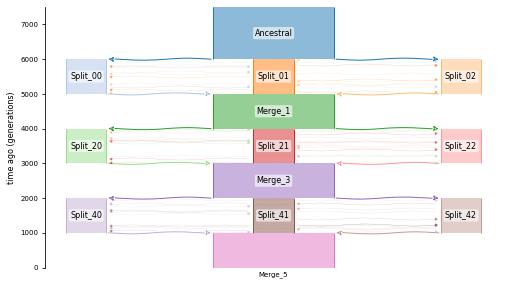

In [8]:
# 1. Specify model - if we are reading from a yaml file
#model = "/home/gfemer/storage/demography-simulations/IM_to_one.yaml"
#model = "/home/gfemer/storage/demography-simulations/example_demes.yaml"

# 2. Visualize Model with demes.draw
#graph = demes.load(model)
demesdraw.tubes(graph, log_time=False, num_lines_per_migration=3)

In [9]:
# Ancestral stats
rhos = np.logspace(-2, 2, 21)
sampled_demes, sample_times, sample_sizes = sample_timepoints('Ancestral',size = 10,time_points = 1)
Ds_ancestral = Dstat(graph, sampled_demes, sample_times,rhos)

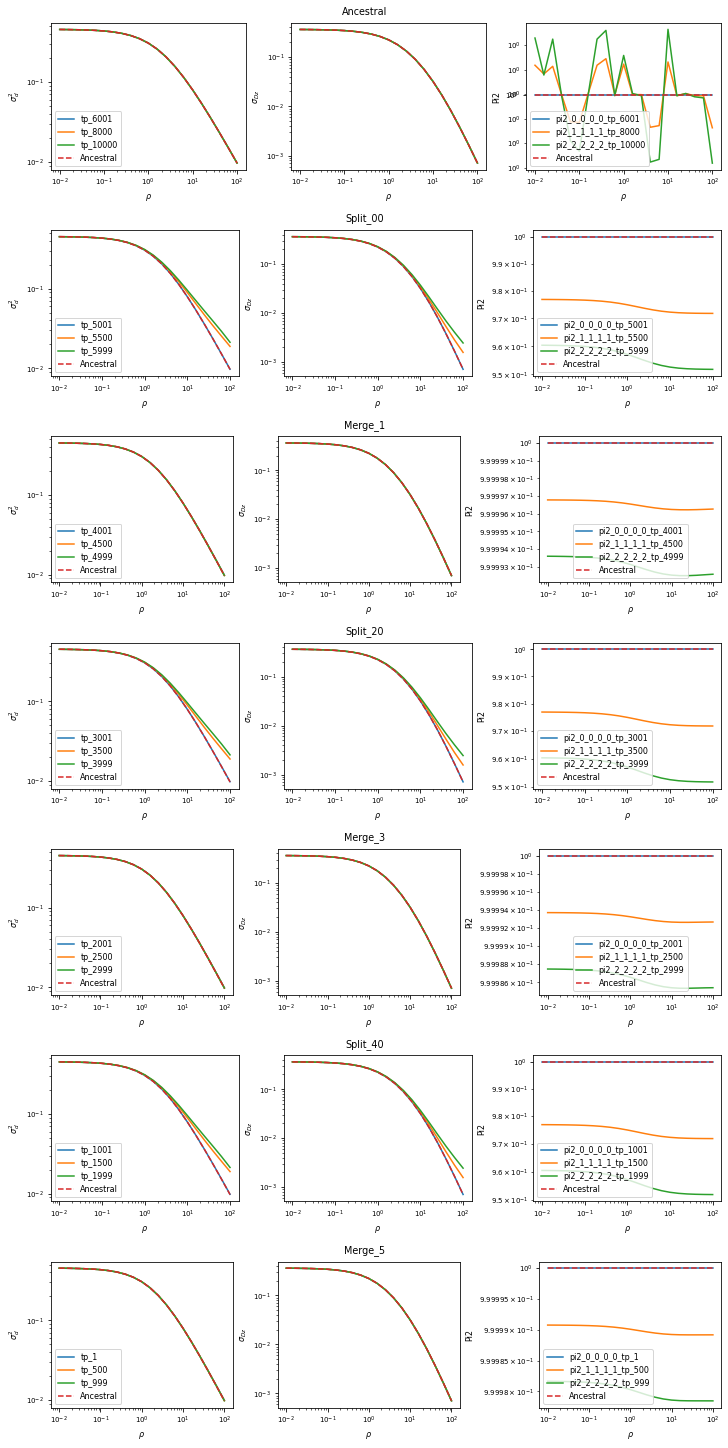

In [10]:
# set up recombination rates
rhos = np.logspace(-2, 2, 21)

# 4. Sample from model different pops and different time points
# fig, axs = plt.subplots(nrows=len(graph.demes), ncols=2)
# plt.subplots_adjust(hspace=0.5)

fig = plt.figure(constrained_layout=True, figsize = (10,20))
#fig.suptitle('Figure title')

demes = []
for deme in graph.demes:
        if "Split" not in deme.name:
                split = 0
                demes.append(deme)
        if "Split" in deme.name and split == 0:
                split = 1
                demes.append(deme)
        if "split" in deme.name and split == 1:
                continue

subfigs = fig.subfigures(nrows=len(demes), ncols=1)

for pop,subfig in zip(demes,subfigs):
        deme = pop.name
        subfig.suptitle(deme)
        sampled_demes, sample_times, sample_sizes = sample_timepoints(deme,size = 10,time_points = 3)
        Ds = Dstat(graph, sampled_demes, np.flip(sample_times),rhos)
        plot_D(Ds,rhos,sample_times,subfig,Ds_ancestral)

plt.show()


In [32]:
# fs = moments.Spectrum.from_demes(
#      graph,
#      sampled_demes=sampled_demes,
#      sample_sizes=sample_sizes,
#      sample_times=sample_times,
# )


In [ ]:
# compare to neutral SFS for YRI
fig = plt.figure()
ax = plt.subplot(111)
ax.semilogy(fs, "-o", ms=6, lw=1, mfc="w", label="Neutral");
ax.set_ylabel("Density");
ax.set_xlabel("Derived allele count");
ax.legend();